# Choosing parameters

This notebook documents the choice of simulation parameters including:

* Length of warm-up period
* Number of replications
* Number of CPU cores

The run time is provided at the end of the notebook.

<!--TODO: Look into HPDM097 choosing distributions and consider whether to include -->

Credit:

* Code for choice of warm-up period and replication number was adapted from Tom Monks (2024) [HPDM097 - Making a difference with health data](https://github.com/health-data-science-OR/stochastic_systems) (MIT Licence).
* Code for running the model with a varying number of CPU cores was adapted from Sammi Rosser and Dan Chalk (2024) [HSMA - the
    little book of DES](https://github.com/hsma-programme/hsma6_des_book) (MIT Licence).

Licence:

* This project is licensed under the MIT Licence. See the `LICENSE` file for more details.

## Set-up

Load notebook linters.

In [1]:
%load_ext pycodestyle_magic

In [2]:
%pycodestyle_on

Load required packages.

In [3]:
# To ensure any updates to `simulation/` are fetched without needing to restart
# the notebook environment, reload `simulation/` before execution of each cell
%load_ext autoreload
%autoreload 1
%aimport simulation

In [4]:
from simulation.model import Defaults, Runner, summary_stats

from IPython.display import display
import os
import pandas as pd
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import plotly.subplots as sp
import time
import warnings

Display plotly express figures as non-interactive figures. This means they will be visible when browsing the notebooks on GitHub. To switch these back to interactive figures, simply remove this line.

In [5]:
pio.renderers.default = 'svg'

Start timer.

In [6]:
notebook_start_time = time.time()

Define path to outputs folder

In [7]:
output_dir = '../outputs/'

## Choosing length of warm-up period

A suitable length for the warm-up period can be determined using the **time series inspection approach**. This involves looking at performance measures over time to identify when the system is exhibiting **steady state behaviour** (even though the system will never truly reach a "steady state").

If we simply plot the mean result at regular intervals, this would vary too much. Therefore, we plot the **cumulative mean** of the performance measure, and look for the point at which this **smoothes out and stabilises**. This indicates the point for the warm-up period to end.

This should be assessed when running the model using the base case parameters. If these change, you should reassess the appropriate warm-up period.

In [8]:
def time_series_inspection(file, data_collection_period, warm_up=None):
    """
    Time series inspection method for determining length of warm-up.

    Arguments:
        file (str):
            Filename to save figure to.
        data_collection_period (float):
            Length of time to run the simulation for.
        warm_up (float, optional):
            Location on X axis to plot vertical red line indicating the chosen
            warm-up period. Defaults to None, which will not plot a line.
    """
    # Use default parameters, but with no warm-up and specified run length,
    # and with no replications
    param = Defaults()
    param.warm_up_period = 0
    param.data_collection_period = data_collection_period
    param.number_of_runs = 1
    # display(param.__dict__)

    # Run model
    choose_warmup = Runner(param)
    choose_warmup.run_reps()

    # Filter to nurse results
    nurse = choose_warmup.interval_audit_df[
        choose_warmup.interval_audit_df['resource_name'] == 'nurse']

    # Define columns to analyse
    plot = {
        'utilisation': 'Cumulative mean nurse utilisation',
        'running_mean_wait_time': 'Running mean nurse wait time'
    }

    # Create 1x2 subplot
    full_figure = sp.make_subplots(rows=2, cols=1, shared_xaxes=True)

    i = 1
    for var, label in plot.items():
        # Reformat so index is simulation time and columns are each run
        reformat = (
            nurse[['simulation_time', var, 'run']]
            .pivot(index='simulation_time',
                   columns='run',
                   values=var))

        # For utilisation, calculate cumulative mean (not necessary
        # for wait time as that is already a running mean)
        if var == 'utilisation':
            cumulative = reformat.expanding().mean()
        elif var == 'running_mean_wait_time':
            cumulative = reformat.copy()

        # Create plot (using go.Scatter instead of px.express, for sub-plots)
        full_figure.add_trace(
            go.Scatter(
                x=cumulative.index,
                y=cumulative[0],
                mode='lines',
                line=dict(color='royalblue')
            ),
            row=i, col=1
        )

        # Add y axis label
        full_figure.update_yaxes(title_text=label, row=i, col=1)

        # Add vertical line for warm-up period specified
        if warm_up is not None:
            full_figure.add_vline(
                x=warm_up, line_color='red', line_dash='dash',
                annotation_text='Suggested warm-up length',
                annotation_position='top left',
                annotation_font_color='red')
        i += 1

    # Add x axis title
    full_figure.update_xaxes(title_text='Run time (minutes)')

    # Set figure dimensions and hide legend
    full_figure.update_layout(
        width=1400,
        height=800,
        showlegend=False
    )

    # Show figure
    full_figure.show()

    # Save figure
    full_figure.write_image(os.path.join(output_dir, file))

Having run the model for three days, it appears to reach a steady state at around 2500 minutes.

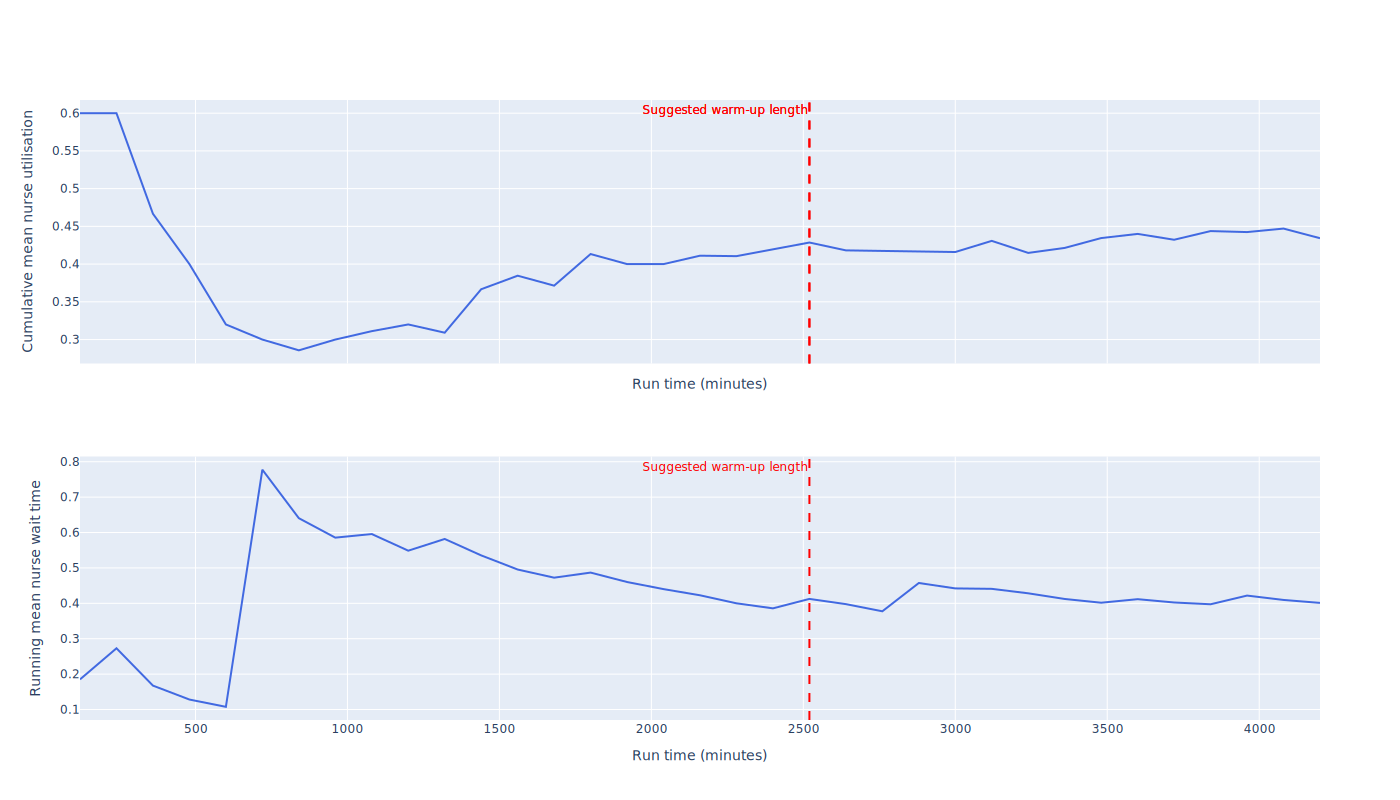

In [9]:
time_series_inspection(file='choose_param_time_series_1.png',
                       data_collection_period=1440*3, warm_up=2520)

However, it is important to look far ahead - so we run it for more days, and find actually a later warm-up is more appropriate.

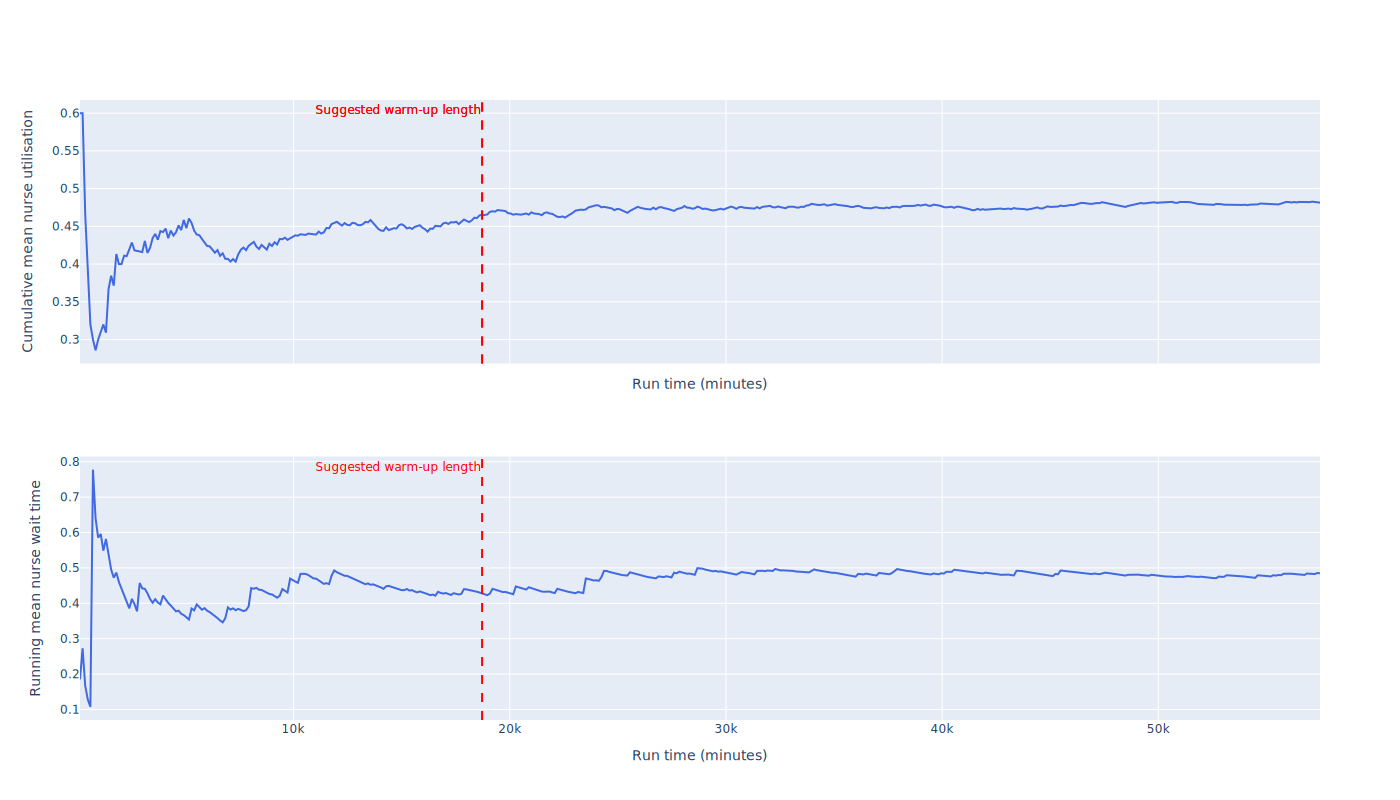

In [10]:
time_series_inspection(file='choose_param_time_series_2.png',
                       data_collection_period=1440*40, warm_up=1440*13)

## Choosing the number of replications

The **confidence interval method** can be used to select the number of replications to run. The more replications you run, the narrower your confidence interval becomes, leading to a more precise estimate of the model's mean performance.

First, you select a desired confidence interval - for example, 95%. Then, run the model with an increasing number of replications, and identify the number required to achieve that precision in the estimate of a given metric - and also, to maintain that precision (as the intervals may converge or expand again later on).

This method is less useful for values very close to zero - so, for example, when using utilisation (which ranges from 0 to 1) it is recommended to multiple values by 100.

When selecting the number of replications you should repeat the analysis for all performance measures and select the highest value as your number of replications.

In [11]:
def confidence_interval_method(file, replications, metric, desired_precision,
                               yaxis_title, min_rep=None):
    """
    Use the confidence interval method to select the number of replications.

    Arguments:
        file (str):
            Filename to save figure to.
        replications (int):
            Number of times to run the model.
        metric (string):
            Name of performance metric to assess.
        desired_precision (float):
            Desired mean deviation from confidence interval.
        yaxis_title (str):
            Label for y axis.
        min_rep (int):
            A suggested minimum number of replications.
    """
    param = Defaults()
    param.number_of_runs = replications
    choose_rep = Runner(param)
    choose_rep.run_reps()

    # If mean of metric is less than 1, multiply by 100
    if choose_rep.run_results_df[metric].mean() < 1:
        choose_rep.run_results_df[f'adj_{metric}'] = (
            choose_rep.run_results_df[metric]*100)
        metric = f'adj_{metric}'

    # Initialise list to store the results
    cumulative_list = []

    # For each row in the dataframe, filter to rows up to the i-th replication
    # then perform calculations
    for i in range(1, replications+1):
        mean, std_dev, ci_lower, ci_upper = summary_stats(
            choose_rep.run_results_df[metric].iloc[:i])
        deviation = ((ci_upper-mean)/mean)*100
        cumulative_list.append({
            'replications': i,
            'cumulative_mean': mean,
            'cumulative_std': std_dev,
            'lower_ci': ci_lower,
            'upper_ci': ci_upper,
            'perc_deviation': deviation
        })
    cumulative = pd.DataFrame(cumulative_list)
    display(cumulative)

    # Get minimum number of replications where deviation is less than target
    try:
        n_reps = cumulative[cumulative['perc_deviation']
                            <= desired_precision*100].iloc[0].name + 1
        print(f'Reached desired precision ({desired_precision}) in {n_reps} ' +
              'replications.')
    except IndexError:
        warnings.warn(f'Running {replications} replications did not reach' +
                      f'desired precision ({desired_precision}).')

    # Plot the cumulative mean and confidence interval
    fig = px.line(cumulative,
                  x='replications',
                  y=['cumulative_mean', 'lower_ci', 'upper_ci'])
    fig.update_layout(
        xaxis_title='Number of replications',
        yaxis_title=yaxis_title
    )
    if min_rep is not None:
        fig.add_vline(x=min_rep, line_color='red', line_dash='dash')

    # Show figure
    fig.show()

    # Save figure
    fig.write_image(os.path.join(output_dir, file))

,replications,cumulative_mean,cumulative_std,lower_ci,upper_ci,perc_deviation
0,1,9.842268,NaN,NaN,NaN,NaN
1,2,9.951374,0.154300,8.565044,11.337705,13.931046
2,3,9.942591,0.110162,9.668933,10.216249,2.752379
3,4,9.941208,0.089990,9.798014,10.084401,1.440402
4,5,9.956147,0.084791,9.850865,10.061429,1.057456
5,6,9.944288,0.081212,9.859062,10.029515,0.857039
6,7,9.958219,0.082792,9.881649,10.034788,0.768908
7,8,9.974314,0.089150,9.899783,10.048845,0.747229
8,9,9.999642,0.112818,9.912922,10.086362,0.867231
9,10,10.008938,0.110354,9.929996,10.087880,0.788718


Reached desired precision (0.05) in 3 replications.


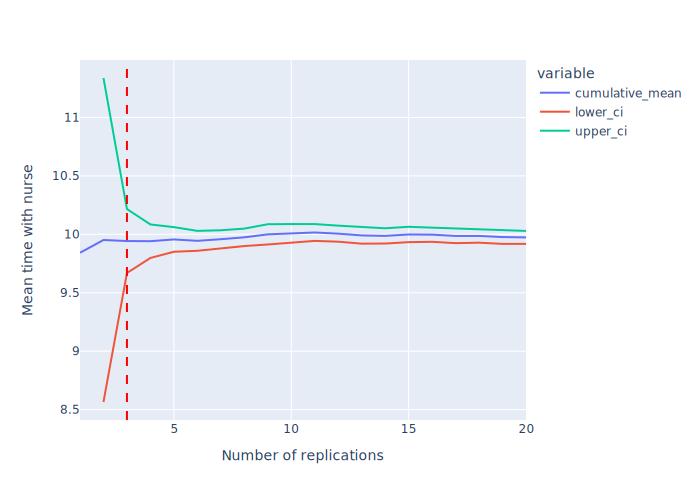

In [12]:
confidence_interval_method(
    file='choose_param_conf_int_1.png',
    replications=20,
    metric='mean_time_with_nurse',
    desired_precision=0.05,
    yaxis_title='Mean time with nurse',
    min_rep=3
)

It is important to check ahead 10-20 replications, to check that the 5% precision is maintained. For this example, 3 replications is < 5, but then it quickly goes back up, and is not stable until 31 replications.

,replications,cumulative_mean,cumulative_std,lower_ci,upper_ci,perc_deviation
0,1,50.454108,NaN,NaN,NaN,NaN
1,2,50.934587,0.679499,44.829530,57.039643,11.986073
2,3,51.397555,0.934815,49.075346,53.719764,4.518132
3,4,50.526888,1.901271,47.501541,53.552234,5.987597
4,5,49.650659,2.559298,46.472872,52.828447,6.400293
5,6,47.846628,4.976664,42.623939,53.069317,10.915480
6,7,47.681940,4.563900,43.461036,51.902843,8.852205
7,8,49.545302,6.755037,43.897949,55.192654,11.398361
8,9,49.245792,6.382325,44.339903,54.151681,9.962047
9,10,49.955562,6.422290,45.361333,54.549792,9.196632


Reached desired precision (0.05) in 3 replications.


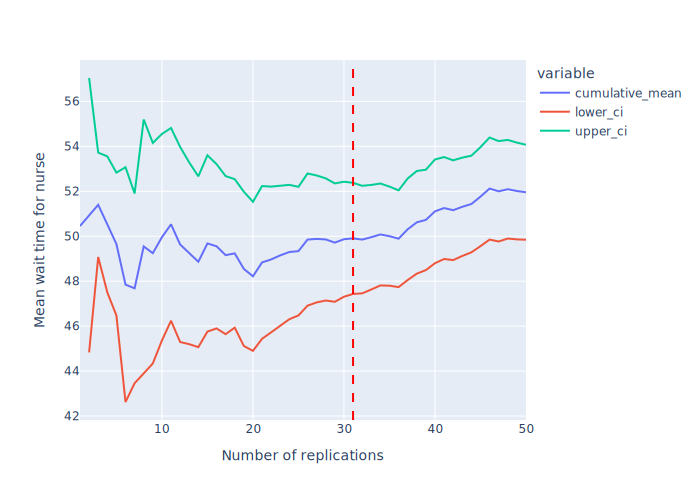

In [13]:
confidence_interval_method(
    file='choose_param_conf_int_2.png',
    replications=50,
    metric='mean_q_time_nurse',
    desired_precision=0.05,
    yaxis_title='Mean wait time for nurse',
    min_rep=31
)

,replications,cumulative_mean,cumulative_std,lower_ci,upper_ci,perc_deviation
0,1,49.963865,NaN,NaN,NaN,NaN
1,2,50.081459,0.166304,48.587275,51.575644,2.983507
2,3,49.991963,0.194570,49.508625,50.475301,0.966831
3,4,49.949485,0.180155,49.662817,50.236152,0.573914
4,5,49.896994,0.195238,49.654574,50.139415,0.485842
5,6,49.795899,0.303011,49.477908,50.113890,0.638588
6,7,49.873003,0.343698,49.555136,50.190870,0.637353
7,8,49.931989,0.359288,49.631617,50.232361,0.601563
8,9,50.037224,0.461108,49.682785,50.391663,0.708350
9,10,50.033219,0.434921,49.722095,50.344343,0.621834


Reached desired precision (0.05) in 2 replications.


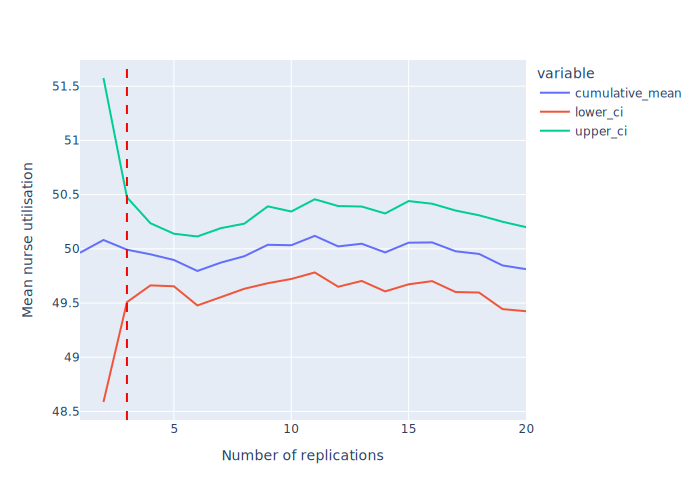

In [14]:
confidence_interval_method(
    file='choose_param_conf_int_3.png',
    replications=20,
    metric='mean_nurse_utilisation',
    desired_precision=0.05,
    yaxis_title='Mean nurse utilisation',
    min_rep=3
)

## Run time with varying number of CPU cores

These are rounded to the nearest .5 seconds, as we will see minor differences in run time between re-runs of this notebook on the same machine, so rounding prevents the figure from changing with every run!

Running with cores: 1.
Running with cores: 2.
Running with cores: 3.
Running with cores: 4.
Running with cores: 5.
Running with cores: 6.
Running with cores: 7.
Running with cores: 8.
   cores  run_time
0      1      10.5
1      2       8.5
2      3       6.5
3      4       6.0
4      5       4.5
5      6       4.5
6      7       4.5
7      8       2.5


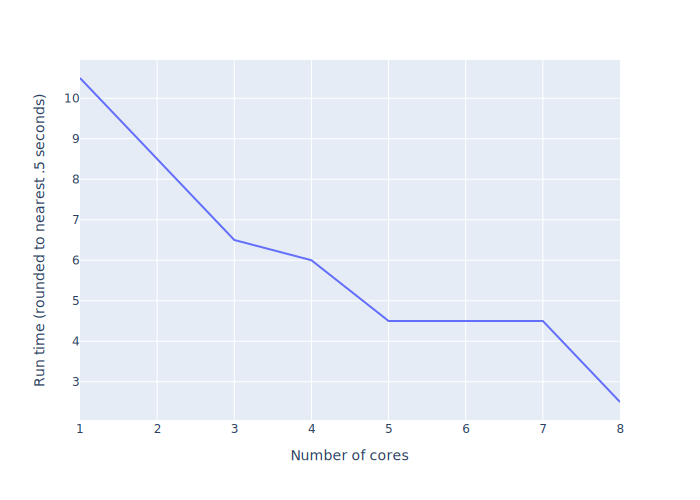

In [15]:
# Run with 1 to 8 cores
speed = []
for i in range(1, 9):
    print(f'Running with cores: {i}.')
    start_time = time.time()

    param = Defaults()
    param.cores = i
    experiment = Runner(param)
    experiment.run_reps()

    # Round time to nearest .5 seconds
    run_time = round((time.time() - start_time)*2)/2
    speed.append({'cores': i, 'run_time': run_time})

# Plot time by number of cores
timing_results = pd.DataFrame(speed)
print(timing_results)
fig = px.line(timing_results, x='cores', y='run_time')
fig.update_layout(
    xaxis_title='Number of cores',
    yaxis_title='Run time (rounded to nearest .5 seconds)'
)

# Display and save figure
fig.show()
fig.write_image(os.path.join(output_dir, 'choose_param_cores.png'),
                width=800, height=600)

## Run time

In [16]:
# Get run time in seconds
notebook_end_time = time.time()
runtime = round(notebook_end_time - notebook_start_time)

# Display converted to minutes and seconds
print(f'Notebook run time: {runtime // 60}m {runtime % 60}s')

Notebook run time: 1m 5s
